In [2]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = sqlite3.connect("../db/stocks.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('growth_stock',), ('value_stock',), ('inflation_5yr',), ('exchange',), ('CPI',), ('leverage',), ('spending',), ('GDP',), ('treasury_10yr',)]


In [60]:
cmd = '''
SELECT g.Date AS Date,
        g."Adj Close" AS GrowthStock_AdjClose,
        (g."Adj Close" - LAG(g."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(g."Adj Close", 1) OVER (ORDER BY g.Date) AS GrowthStock_PercentChange,
        
        v."Adj Close" AS ValueStock_AdjClose,
        (v."Adj Close" - LAG(v."Adj Close", 1) OVER (ORDER BY v.Date))/ 
                LAG(v."Adj Close", 1) OVER (ORDER BY v.Date) AS ValueStock_PercentChange,
        
        t."Adj Close" AS Treasury10yr_AdjClose,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date))/ 
                LAG(t."Adj Close", 1) OVER (ORDER BY t.Date) AS Treasury10yr_PercentChange,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date)) AS Treasury10yr_Diff,
        
        e.DEXCAUS AS exchange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date))/ 
                LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date) AS exchange_PercentChange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date)) AS exchange_Diff,
        
        i.T5YIE AS inflation5yr,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date))/ 
                LAG(i.T5YIE, 1) OVER (ORDER BY i.Date) AS inflation5yr_PercentChange,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date)) AS inflation5yr_Diff,
        
        c.CPIAUCSL_PC1 AS CPI,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date))/ 
                LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date) AS CPI_PercentChange,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date)) AS CPI_Diff
        
FROM growth_stock g
LEFT JOIN value_stock v
ON g.Date = v.Date
LEFT JOIN treasury_10yr t
ON g.Date = t.Date
LEFT JOIN exchange e
ON g.Date = e.Date
LEFT JOIN inflation_5yr i
ON g.Date = i.Date
LEFT JOIN CPI c
ON g.Date = c.Date
'''

df = pd.read_sql_query(cmd, conn)
df.head()

,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,ValueStock_AdjClose,ValueStock_PercentChange,Treasury10yr_AdjClose,Treasury10yr_PercentChange,Treasury10yr_Diff,exchange,exchange_PercentChange,exchange_Diff,inflation5yr,inflation5yr_PercentChange,inflation5yr_Diff,CPI,CPI_PercentChange,CPI_Diff
0,2000-05-26,15.213005,NaN,36.438076,NaN,6.320,NaN,NaN,1.5045,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2000-05-30,15.844181,0.041489,36.994823,0.015279,6.367,0.007437,0.047,1.5036,-0.000598,-0.0009,None,NaN,NaN,NaN,NaN,NaN
2,2000-05-31,15.806020,-0.002409,37.273205,0.007525,6.285,-0.012879,-0.082,1.4977,-0.003924,-0.0059,None,NaN,NaN,NaN,NaN,NaN
3,2000-06-01,16.040890,0.014860,37.733952,0.012361,6.195,-0.014320,-0.090,1.4910,-0.004474,-0.0067,None,NaN,NaN,3.73494,NaN,NaN
4,2000-06-02,16.569317,0.032942,38.261909,0.013992,6.148,-0.007587,-0.047,1.4785,-0.008384,-0.0125,None,NaN,NaN,NaN,NaN,NaN


In [61]:
df['Date'] = pd.to_datetime(df['Date'])

In [62]:
df.isna().sum()

Date                             0
GrowthStock_AdjClose             0
GrowthStock_PercentChange        1
ValueStock_AdjClose              0
ValueStock_PercentChange         1
Treasury10yr_AdjClose            7
Treasury10yr_PercentChange      13
Treasury10yr_Diff               13
exchange                         1
exchange_PercentChange          53
exchange_Diff                    2
inflation5yr                   651
inflation5yr_PercentChange     689
inflation5yr_Diff              652
CPI                           5294
CPI_PercentChange             5295
CPI_Diff                      5295
dtype: int64

In [63]:
df['CPI'] = df.CPI.fillna(method = 'ffill', limit = 30)
df['CPI_PercentChange'] = df.CPI_PercentChange.fillna(method = 'ffill', limit = 30)
df['CPI_Diff'] = df.CPI_Diff.fillna(method = 'ffill', limit = 30)

In [64]:
df.isna().sum()

Date                             0
GrowthStock_AdjClose             0
GrowthStock_PercentChange        1
ValueStock_AdjClose              0
ValueStock_PercentChange         1
Treasury10yr_AdjClose            7
Treasury10yr_PercentChange      13
Treasury10yr_Diff               13
exchange                         1
exchange_PercentChange          53
exchange_Diff                    2
inflation5yr                   651
inflation5yr_PercentChange     689
inflation5yr_Diff              652
CPI                           1191
CPI_PercentChange             1222
CPI_Diff                      1222
dtype: int64

In [72]:
df = df.dropna()

## EDA and Visualizations

In [102]:
def compare_indices(data, col_A, col_B):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
#     fig.suptitle('Pokemon Stats by Generation')

    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_A, alpha = 0.6, label = col_A.split('_')[0])
    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_B, alpha = 0.6, label = col_B.split('_')[0])
#     plt.legend()
    sns.scatterplot(ax=axes[1], x = col_A, y = col_B, size = 0.1, data = data)
    return fig, axes

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='Date', ylabel='GrowthStock_PercentChange'>,
        <AxesSubplot:xlabel='GrowthStock_PercentChange', ylabel='Treasury10yr_PercentChange'>],
       dtype=object))

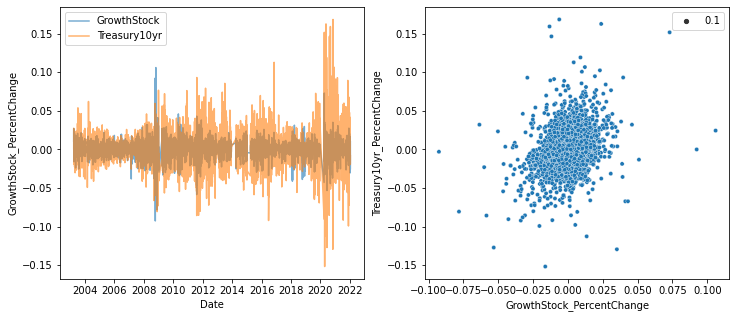

In [103]:
compare_indices(df, 'GrowthStock_PercentChange', 'Treasury10yr_PercentChange')

Text(0, 0.5, '% Change')

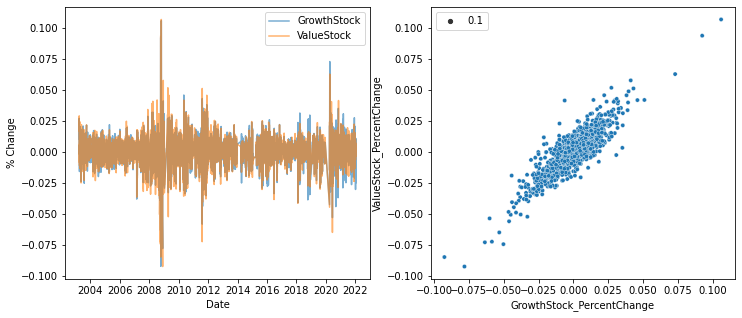

In [104]:
fig, axes = compare_indices(df, 'GrowthStock_PercentChange', 'ValueStock_PercentChange')
axes[0].set_ylabel('% Change')

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_AdjClose'>

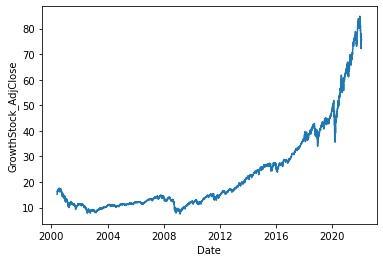

In [65]:
sns.lineplot(y='GrowthStock_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_PercentChange'>

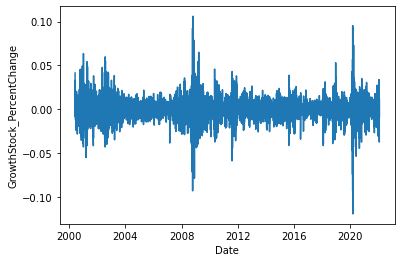

In [66]:
sns.lineplot(y='GrowthStock_PercentChange', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasury10yr_AdjClose'>

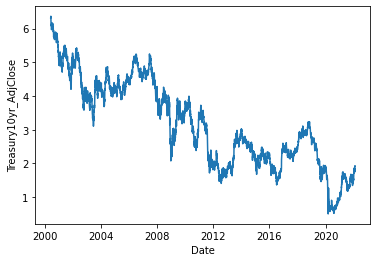

In [67]:
sns.lineplot(y='Treasury10yr_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasury10yr_Diff'>

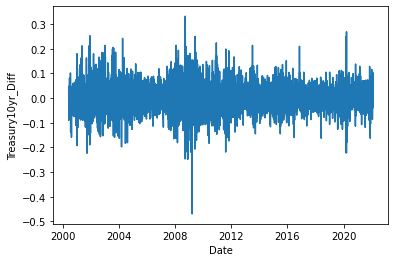

In [68]:
sns.lineplot(y='Treasury10yr_Diff', x='Date', data = df)

<AxesSubplot:xlabel='Treasury10yr_Diff', ylabel='GrowthStock_PercentChange'>

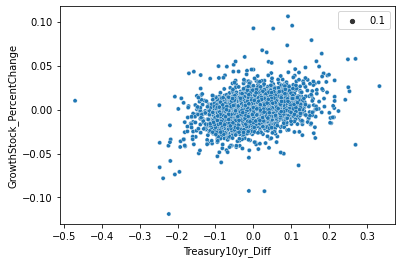

In [69]:
plt.figure(figsize = (6,4))
sns.scatterplot(x = 'Treasury10yr_Diff', 
                y = 'GrowthStock_PercentChange',
                size = 0.1,
                data = df)

## Linear Regression

In [70]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence

In [73]:
X = df.Treasury10yr_PercentChange
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [74]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.103
Model:                                   OLS   Adj. R-squared:                  0.103
Method:                        Least Squares   F-statistic:                     398.7
Date:                       Thu, 24 Feb 2022   Prob (F-statistic):           4.58e-84
Time:                               00:25:37   Log-Likelihood:                 12059.
No. Observations:                       3477   AIC:                        -2.411e+04
Df Residuals:                           3475   BIC:                        -2.410e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0009      0.000      7.225      0.000       0.001       0.001
Treasury10yr_PercentChange     0.1305      0.007     19.968      0.000       0.118       0.143
==============================================================================
Omnibus:                       42.411   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.605
Skew:                          -0.109   Prob(JB):                     5.67e-15
Kurtosis:                       3.637   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

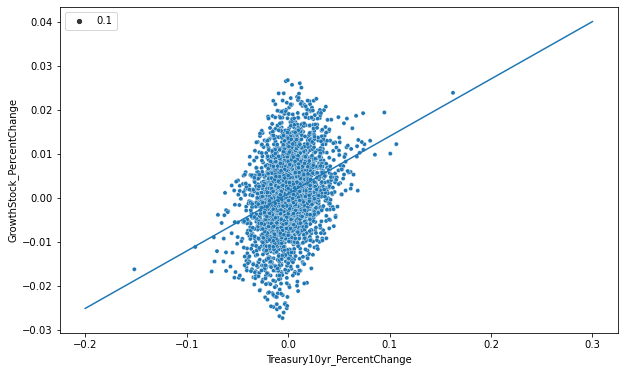

In [76]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.1,
                data = df)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [77]:
X = df.Treasury10yr_Diff
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [78]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [79]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.090
Model:                                   OLS   Adj. R-squared:                  0.090
Method:                        Least Squares   F-statistic:                     343.4
Date:                       Thu, 24 Feb 2022   Prob (F-statistic):           3.51e-73
Time:                               00:25:49   Log-Likelihood:                 12057.
No. Observations:                       3483   AIC:                        -2.411e+04
Df Residuals:                           3481   BIC:                        -2.410e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      7.751      0.000       0.001       0.001
Treasury10yr_Diff     0.0510      0.003     18.530      0.000       0.046       0.056
==============================================================================
Omnibus:                       41.403   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.878
Skew:                          -0.098   Prob(JB):                     8.17e-15
Kurtosis:                       3.639   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

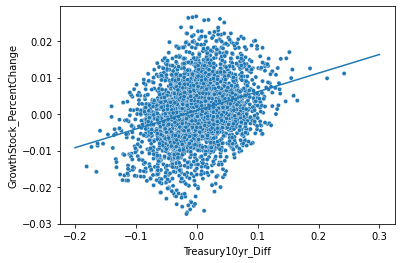

In [80]:
plt.figure(figsize = (6,4))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.01,
                data = df,
               legend = False)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [47]:
IVW.Date = pd.to_datetime(IVW.Date)
IVW['Diff'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))
IVW['Percent_Change'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))/IVW['Adj Close'].shift(1)

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

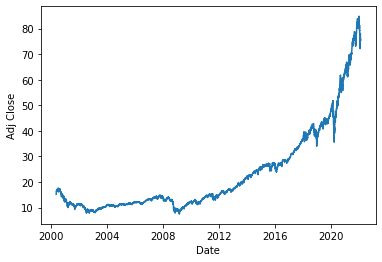

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
Adj_close = IVW['Adj Close']
Adj_close.index = df.Date.apply(lambda x: datetime.fromisoformat(x))
Adj_close.name = "Adj Close"
decomp = seasonal_decompose(Adj_close)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
# Plot decomposition
decomp.plot()
plt.tight_layout()
plt.xlabel('year')